#### Estudo de Caso Nº 1 
    - Análise de dados em operadoras de cartão de crédito
    * O Objetivo do estudo é saber se clientes novos darão calote ou não na operadora, essa informação irá ajudar na decisão de conceder ou não o cartão.
    Os clientes que já derão calote irão ajudar como histórico para essa análise

In [1]:
import numpy
import pandas
#import seaborn
import warnings
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler

from sklearn.preprocessing import power_transform, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
data = pandas.read_csv('EstudoCaso1/database.csv')
data = data.rename({'default payment next month': 'TARGET'}, axis=1) # renomeando coluna para facilitar

data['SEX'] = pandas.Categorical(data['SEX'])
sex_dummies = pandas.get_dummies(data['SEX'], prefix = 'sex') # atraves das opcoes da variavel, se cria colunas

data['MARRIAGE'] = pandas.Categorical(data['MARRIAGE'])
mar_dummies = pandas.get_dummies(data['MARRIAGE'], prefix = 'marr') # atraves das opcoes da variavel, se cria colunas

data = pandas.concat([data, sex_dummies, mar_dummies], axis=1)
data.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,TARGET,sex_0,sex_1,marr_1,marr_2,marr_3
0,50000.0,1,2,1,57,-1,0,-1,0,0,...,10000.0,9000.0,689.0,679.0,0,0,1,1,0,0
1,320000.0,1,1,1,49,0,0,0,-1,-1,...,75940.0,20000.0,195599.0,50000.0,0,0,1,1,0,0
2,500000.0,1,1,1,58,-2,-2,-2,-2,-2,...,3180.0,0.0,5293.0,768.0,0,0,1,1,0,0
3,280000.0,1,2,1,40,0,0,0,0,0,...,6300.0,6400.0,6400.0,6737.0,0,0,1,1,0,0
4,70000.0,1,2,1,39,0,0,0,0,0,...,1000.0,2000.0,3000.0,0.0,0,0,1,1,0,0


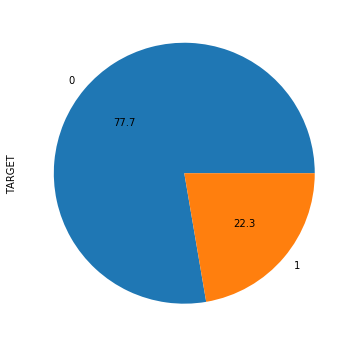

In [4]:
data.groupby('TARGET')['TARGET'].count().plot.pie(autopct='%.1f')

In [20]:
X = data.loc[:, ~data.columns.isin(['TARGET', 'SEX', 'MARRIAGE'])].values # todas as colunas, exceto estas
y = data.loc[:, data.columns.isin(['TARGET'])].values

print(X.shape)
print(y.shape)

(29601, 26)
(29601, 1)


array([[0],
       [0],
       [0],
       [0],
       [0]])

### Balanceando os dados

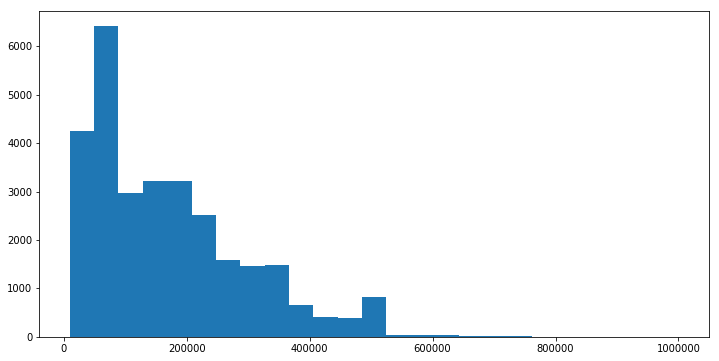

In [6]:
plt.hist(X[:, 0], bins=25)
plt.show()

In [7]:
X_norm = power_transform(X, method='yeo-johnson') # aqui balanceia os dados

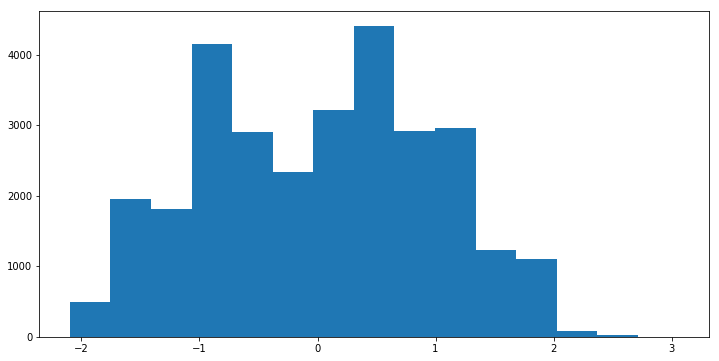

In [8]:
plt.hist(X_norm[:, 0], bins=15)
plt.show()

In [9]:
under_sampler = RandomUnderSampler(random_state=42) #Equilibrar a quantidade de dados
X_rus, y_rus = under_sampler.fit_sample(X_norm, y)#aplicação da seleção dos dados.

print(X_rus.shape)
print(y_rus.shape)

(13210, 26)
(13210, 1)


### Treinamento

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)
y_train.shape

(10568, 1)

In [11]:
y_all = numpy.concatenate([y_train, y_test]).ravel()
unique, counts = numpy.unique(y_all, return_counts=True)
dict(zip(unique, counts))# Aqui garante que os dados de treino e testes estão em mesma quantidade

{0: 6605, 1: 6605}

In [12]:
classifier = RandomForestClassifier(
    n_estimators=200,
    oob_score=True,
    class_weight='balanced_subsample',
    random_state=42
)

classifier

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=True, random_state=42,
            verbose=0, warm_start=False)

In [13]:
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.79      0.74      1332
           1       0.75      0.65      0.70      1310

   micro avg       0.72      0.72      0.72      2642
   macro avg       0.72      0.72      0.72      2642
weighted avg       0.72      0.72      0.72      2642



In [15]:
print(confusion_matrix(y_test, y_pred))

[[1056  276]
 [ 464  846]]
